<a href="https://colab.research.google.com/github/tonythor/dreamteam/blob/afraser/620_hw2_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

This is an analysis of the link data from Wikispeedia. In Wikispeedia, users have to navigate from one Wikipedia page to another using only the links in the articles. The data and an explanation of the game can be found [here](https://snap.stanford.edu/data/wikispeedia.html).

In [1]:
# Imports required libraries and data.

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import random

random.seed(13)

url = "https://raw.githubusercontent.com/Marley-Myrianthopoulos/grad_school_data/main/links.tsv"
df = pd.read_csv(url, sep='\t', skiprows = 12, header = None)
df = df.rename(columns = {0: "source", 1: "target"})
print(df.head())

                             source          target
0  %C3%81ed%C3%A1n_mac_Gabr%C3%A1in            Bede
1  %C3%81ed%C3%A1n_mac_Gabr%C3%A1in         Columba
2  %C3%81ed%C3%A1n_mac_Gabr%C3%A1in  D%C3%A1l_Riata
3  %C3%81ed%C3%A1n_mac_Gabr%C3%A1in   Great_Britain
4  %C3%81ed%C3%A1n_mac_Gabr%C3%A1in         Ireland


We focused our analysis on the Wikipedia pages for the different centuries. When on the page for one century, did players follow links to the pages for other centuries?

In [2]:
# Filters the data frame so that each link connects two century pages

df_3 = df[(df["source"].str.contains(r'century')) & (df["target"].str.contains(r'century'))]
print(df_3.head())

           source        target
115  10th_century  11th_century
116  10th_century   9th_century
141  11th_century  10th_century
142  11th_century  12th_century
143  11th_century  13th_century


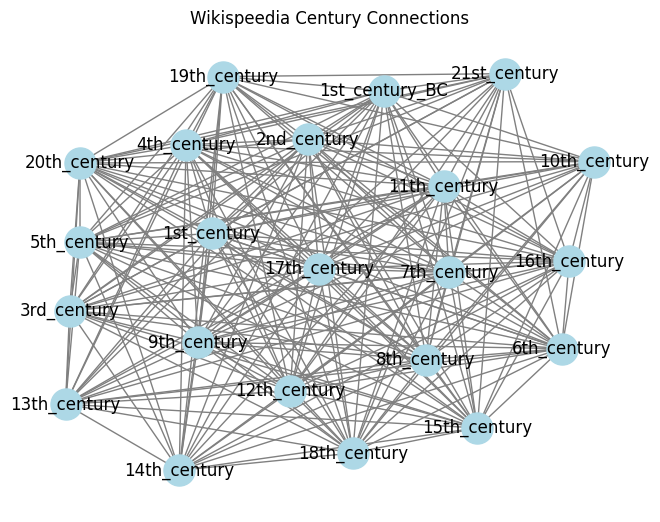

In [3]:
# Creates graph of filtered data
G=nx.from_pandas_edgelist(df_3, "source", "target")
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')
plt.title('Wikispeedia Century Connections')
plt.show()

Each node represents a Wikipedia page for a given century, and each edge represents a direct link followed by a Wikispeedia player from one page to another. We can see from the graph that almost all of the nodes are connected to each other. By analyzing the metrics of this graph, we can gain more insight into these links.

## Analysis of Graph Metrics

In [4]:
# Find density

nx.density(G)

0.9783549783549783

The density of the graph is approximately 0.98.

The density of a graph measures how many edges there are, relative to the maximum number of edges. The maximum density of a graph is 1. The density of this graph is very close to 1 because it is almost a "complete" graph, where each node has an edge connecting it to every other node.

The formula for the density of an undirected graph is $d=\frac{2m}{n(n-1)}$. $m$ represents the number of edges and $n$, the number of nodes. We can replicate our finding above by writing a function for density by hand, using this formula.

In [5]:
# Density function using formula

def find_density(graph):
  n_edges = graph.number_of_edges()
  n_nodes = graph.number_of_nodes()
  d = 2*n_edges/(n_nodes*(n_nodes -1))
  return d

find_density(G)


0.9783549783549783

In a complete graph (with a density of 1.0), the diameter of the graph will also be 1 because the greatest minimum distance between any two nodes will be 1 (since each node is connected to every other node by an edge). Since our graph does not have a density of 1, the diameter must be greater than 1.

In [6]:
# Find diameter

nx.diameter(G,e=None)

2

The diameter of the graph is 2, which means the greatest minimum distance between two nodes is 2.

The diameter of a graph measures the greatest minimum number of edges between two nodes. Since our graph's diameter is 2, this means that there is at least one pair of nodes which are not directly connected, but have at least one direct intermediary node between them. We can replicate our finding above by writing a function for the diameter using a loop and the shortest_path_length function.

In [7]:
# Diameter function using shortest_path_length

def find_diameter(graph):
  nodes = list(graph.nodes())
  shortest_paths_df = pd.DataFrame(index=nodes, columns=nodes)
  for node1 in graph.nodes():
    for node2 in graph.nodes():
      if node1 != node2:
        path_length = nx.shortest_path_length (graph, node1, node2)
        shortest_paths_df.loc[node1, node2] = path_length
  shortest_paths_df.fillna(0, inplace=True)
  diameter = shortest_paths_df.values.max()

  return diameter

find_diameter(G)

/var/folders/47/hrclrfyd42bg6znqdy1_z5q40000gp/T/ipykernel_69913/2103909365.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  shortest_paths_df.fillna(0, inplace=True)


2

## Analysis of Longest Paths

Using the nx.periphery function, we can find the nodes that are diameter endpoints.

In [8]:
nx.periphery(G)

['10th_century', '13th_century', '14th_century', '21st_century']

The 10th_century, 13th_century, 14th_century, and 21st_century nodes are endpoints of diameters. Now it is possible to find the specific paths with a length of 2.

In [9]:
# Creates the combinations of periphery nodes
source_node = ["10th_century", "10th_century", "10th_century", "13th_century", "13th_century", "14th_century"]
target_node = ["13th_century", "14th_century", "21st_century", "14th_century", "21st_century", "21st_century"]
path_length = []

# Finds the distance between each combination of periphery nodes
for i in range(len(source_node)):
  path_length.append(nx.shortest_path_length(G, source = source_node[i], target = target_node[i]))

# Creates a data frame of the findings
df_long_paths = pd.DataFrame({'Source': source_node,
                              'Target': target_node,
                              'Length': path_length})

print(df_long_paths)

         Source        Target  Length
0  10th_century  13th_century       2
1  10th_century  14th_century       2
2  10th_century  21st_century       2
3  13th_century  14th_century       1
4  13th_century  21st_century       2
5  14th_century  21st_century       2


This data frame shows the length of the shortest path from each node in the periphery list above to each other node to determine which nodes are not connected by edges. Any path with a length of 1 indicates that the nodes are connected by an edge. Any path longer than 1 indicates that the nodes are not connected by an edge. From the results, we can see that the 13th_century and 14th_century nodes are connected by an edge, but neither of them is connected by an edge to the 10th_century or 21st_century nodes, and those two nodes are not connected to each other.

No direct links were followed by a Wikispeedia player between...


* The 10th_century and 13th_century pages
* The 10th_century and 14th_century pages
* The 10th_century and 21st_century pages
* The 21st_century and 13th_century pages
* The 21st_century and 14th_century pages

By filtering the data for just these nodes, we can confirm this finding graphically.

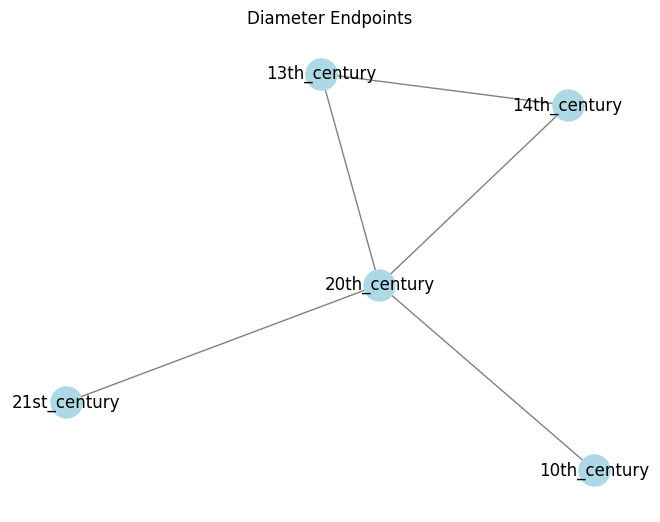

In [10]:
# Creates a graph using just the periphery nodes
second_graph_nodes = nx.periphery(G)
second_graph_nodes.append('20th_century')

df_4 = df_3[(df_3['source'].isin(second_graph_nodes)) & (df_3['target'].isin(second_graph_nodes))]

G2 = nx.from_pandas_edgelist(df_4, 'source', 'target')
pos = nx.spring_layout(G2)
nx.draw(G2, pos, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')
plt.title('Diameter Endpoints')
plt.show()

This graph confirms the finding above that there is an edge connecting the 13th_century and 14th_century nodes to one another, but no edge connecting either of those nodes to the 10th_century or 21st_century nodes, and no edge connecting the 10th_century and 21st_century nodes to each other. The 20th_century node was included so that there was a node that each of the nodes from the periphery list was connected to, but any node besides those four could have served that purpose.